In [1]:
#| label: setup
#| include: false
knitr::opts_chunk$set(echo = TRUE)

## The [**reticulate**](https://rstudio.github.io/reticulate/) package

The [**reticulate**](https://rstudio.github.io/reticulate/) package
provides a comprehensive set of tools for interoperability between
Python and R. The package includes facilities for:

-   Calling Python from R in a variety of ways including R Markdown,
    sourcing Python scripts, importing Python modules, and using Python
    interactively within an R session.
-   Translation between R and Python objects (for example, between R and
    Pandas data frames, or between R matrices and NumPy arrays).
-   Flexible binding to different versions of Python including virtual
    environments and Conda environments.

[**reticulate**](https://rstudio.github.io/reticulate/) embeds a Python
session within your R session, enabling seamless, high-performance
interoperability. If you are an R developer that uses Python for some of
your work or a member of data science team that uses both languages,
[**reticulate**](https://rstudio.github.io/reticulate/) can dramatically
streamline your workflow.

Let us start by loading the
[**reticulate**](https://rstudio.github.io/reticulate/) package into the
environment, along with a suite of useful packages for data science:


In [2]:
# install.packages("tidyverse")
library(tidyverse)
# install.packages("reticulate")
library(reticulate)

The fastest way to get you set up to use Python from R with
[**reticulate**](https://rstudio.github.io/reticulate/) is to use the
`install_python()` and `install_miniconda()` utility functions that are
included in the [**reticulate**](https://rstudio.github.io/reticulate/)
package. In details, use something like:


In [3]:
#| eval: false
version <- "3.9.6"
install_miniconda()
conda_create("r-reticulate", python_version = version)

This is a setup that you ought to do only once (unless you want to
change your Python version for some reason).

Next, you can seamlessly install all the Python packages you need by
calling the `conda_install()` function. For instance, to use Gudhi, you
would do something like:


In [4]:
#| eval: false
conda_install("scikit-learn", envname = "r-reticulate")
conda_install("gudhi", envname = "r-reticulate")
conda_install("jupyter", envname = "r-reticulate")
conda_install("r" , envname = "r-reticulate")
conda_install("r-irkernel" , envname = "r-reticulate")
install.packages("IRkernel")
IRkernel::installspec()

Again, installation of Python packages is to be done only once.

You finally need to tell your R markdown document which conda
environment to use for interpreting Python code. This is done with:


In [5]:
use_condaenv("r-reticulate")

If you want to check your Python configuration, you can do:


In [6]:
py_config()

python:         /Users/stamm-a/Library/r-miniconda/envs/r-reticulate/bin/python
libpython:      /Users/stamm-a/Library/r-miniconda/envs/r-reticulate/lib/libpython3.9.dylib
pythonhome:     /Users/stamm-a/Library/r-miniconda/envs/r-reticulate:/Users/stamm-a/Library/r-miniconda/envs/r-reticulate
version:        3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15)  [Clang 11.1.0 ]
numpy:          /Users/stamm-a/Library/r-miniconda/envs/r-reticulate/lib/python3.9/site-packages/numpy
numpy_version:  1.22.4

NOTE: Python version was forced by use_python function

You can now create chunks of Python code that will be correctly
interpreted when knitting your document into an HTML file. Let us make a
first Python chunk of code to import **numpy** and **gudhi**:


```{python}
#| eval: false
import numpy as np
import gudhi as gd
import gudhi.representations
```


## Full example

### Data model

First, we will generate persistence diagrams with orbits of dynamical
systems. This data set is very common in TDA. We use the following
system, which depends on a parameter $r > 0$:


$$
\begin{cases}
x_{n+1} = x_n + r y_n (1 - y_n) \mbox{ mod } 1 \\
y_{n+1} = y_n + r x_{n+1} (1 - x_{n+1}) \mbox{ mod } 1
\end{cases}
$$


Let's first see what the point cloud looks like for a given choice of
$r$.

We first define a **Python** function to compute a single point cloud
according to the above orbit model and then use the
[**Gudhi**](https://gudhi.inria.fr) library to compute the persistence
diagrams from its alpha complex and turn it into its silhouette
representation. This can be achieved by a function that looks like:


```{python}
#| eval: false
def orbit_silhouette(num_pts = 1000, resolution = 1000, r = 2):
  X = np.empty([num_pts, 2])
  x, y = np.random.uniform(), np.random.uniform()
  for i in range(num_pts):
    X[i, :] = [x, y]
    x = (X[i, 0] + r * X[i, 1] * (1 - X[i, 1])) % 1.
    y = (X[i, 1] + r * x * (1 - x)) % 1.
  acX = gd.AlphaComplex(points = X).create_simplex_tree()
  dgmX = acX.persistence()
  SH = gd.representations.Silhouette(
    resolution = resolution, 
    weight = lambda x: np.power(x[1] - x[0], 1)
  )
  sh = SH.fit_transform([acX.persistence_intervals_in_dimension(1)])
  return([np.linspace(SH.sample_range[0], SH.sample_range[1], resolution), sh[0]])
```

In [7]:
#| echo: false
source_python("orbit_silhouette.py")

This function returns a Python list of size 2. The first element is the
abscissa grid and the second element is the silhouette value on the
grid.

Python lists are automatically converted into atomic vectors in R.
Automatic conversions of data types between R and Python languages are
achieved according to the following table:

| R                      | Python            | Examples                                           |
|------------------|------------------|------------------------------------|
| Single-element vector  | Scalar            | `1`, `1L`, `TRUE`, `"foo"`                         |
| Multi-element vector   | List              | `c(1.0, 2.0, 3.0)`, `c(1L, 2L, 3L)`                |
| List of multiple types | Tuple             | `list(1L, TRUE, "foo")`                            |
| Named list             | Dict              | `list(a = 1L, b = 2.0)`, `dict(x = x_data)`        |
| Matrix/Array           | NumPy ndarray     | `matrix(c(1, 2, 3, 4), nrow = 2, ncol = 2)`        |
| Data Frame             | Pandas DataFrame  | `data.frame(x = c(1, 2, 3), y = c("a", "b", "c"))` |
| Function               | Python function   | `function(x) x + 1`                                |
| NULL, TRUE, FALSE      | None, True, False | `NULL`, `TRUE`, `FALSE`                            |

### Sample generation

Now we can go back in **R** to use this **Python** function and generate
two samples of silhouette profiles. To access any Python object
`my_py_object` created in a previous chunk from an R chunk, use
`py$my_py_object`. Following this logic, the Python
function`orbit_silhouette()` created in the above Python chunk is
accessible from any subsequent R chunk as `py$orbit_silhouette()`:


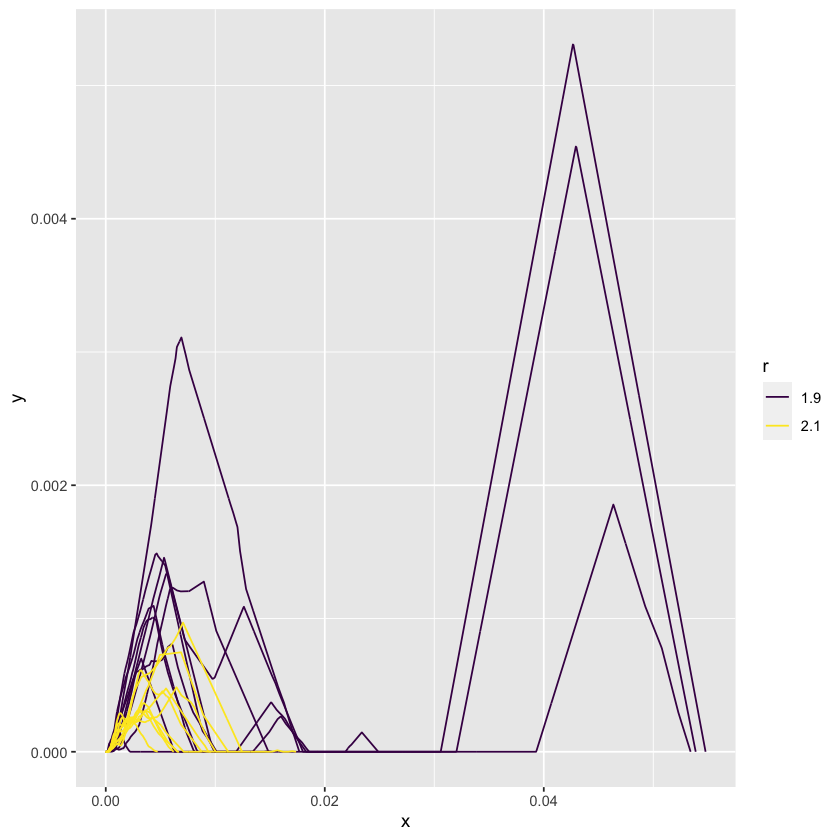

In [8]:
n1 <- 10
n2 <- 10
x1 <- replicate(n1, orbit_silhouette(r = 1.9), simplify = FALSE)
x2 <- replicate(n2, orbit_silhouette(r = 2.1), simplify = FALSE)
# x1 <- replicate(n1, py$orbit_silhouette(r = 1.9), simplify = FALSE)
# x2 <- replicate(n2, py$orbit_silhouette(r = 2.1), simplify = FALSE)

t1 <- x1 |> map(1) |> map(~ c(0, .x))
x1 <- x1 |> map(2) |> map(~ c(0, .x))
t2 <- x2 |> map(1) |> map(~ c(0, .x))
x2 <- x2 |> map(2) |> map(~ c(0, .x))

df <- bind_rows(
  tibble(id = 1:n1, x = t1, y = x1) |> 
    unnest(cols = c(x, y)) |> 
    mutate(r = "1.9"), 
  tibble(id = 1:n2, x = t2, y = x2) |> 
    unnest(cols = c(x, y)) |> 
    mutate(r = "2.1")
) |> 
  mutate(
    id = as_factor(id), 
    r = as_factor(r)
  )
df |> 
  ggplot(aes(x, y, color = r, group = interaction(id, r))) +
  geom_line() + 
  scale_color_viridis_d()